In [324]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc
from sklearn.neural_network import MLPClassifier

In [325]:
class fc:
    def __init__(self,left,right,ba=None,fo=None):
        self.left = left
        self.right = right
        self.data = np.zeros(left)
        self.weight = np.random.random((right,left))
        self.bias = np.random.random(right)
        self.ba = ba
        self.fo = fo
        self.cumgrad = np.zeros((right,left))
        self.bgrad = np.zeros(right)
        self.sigmoid_cumgrad = np.zeros((right,left))
        self.sigmoid_bgrad = np.zeros(right)
    def predict(self,data):
        fodata = self.weight @ data + self.bias
        return self.fo.predict(fodata)

    def forward(self,data,label):
        self.data = data
        fodata = self.weight @ data + self.bias
        self.fo.forward(fodata,label)

    def backward(self,grady):
        gradyx = np.sum(grady.reshape(-1,1) * self.weight,axis=0)
        self.cumgrad += grady.reshape(-1,1) * self.data.reshape(1,-1)
        self.bgrad += grady
        if self.ba is not None:
            self.ba.backward(gradyx)
    def step(self,lamb):
        self.weight -= lamb * self.cumgrad
        self.bias -= lamb * self.bgrad
        self.cumgrad = np.zeros((right,left))
        self.bgrad = np.zeros(right)
        return self.fo.step(lamb)
    def newstep(self,lamb,alpha):
        if np.all(self.sigmoid_cumgrad == 0) and np.all(self.sigmoid_bgrad == 0):
            self.sigmoid_cumgrad = self.cumgrad
            self.sigmoid_bgrad = self.bgrad
        else:
            self.sigmoid_cumgrad = (alpha * (self.sigmoid_cumgrad ** 2) + (1-alpha) * (self.cumgrad ** 2)) ** (0.5)
            self.sigmoid_bgrad = (alpha * (self.sigmoid_bgrad ** 2) + (1-alpha) * (self.bgrad ** 2)) ** (0.5)
        for i in range(self.right):
            for j in range(self.left):
                if self.sigmoid_cumgrad[i,j] != 0:
                    self.weight[i,j] -= lamb * self.cumgrad[i,j] / self.sigmoid_cumgrad[i,j]
        for k in range(self.right):
            if self.sigmoid_bgrad[k] != 0:
                self.bias[k] -= lamb * self.bgrad[k] / self.sigmoid_bgrad[k]
        self.cumgrad = 0
        self.bgrad = 0
        return self.fo.newstep(lamb,alpha)

In [326]:
class crossentropy:
    def __init__(self, left, ba=None):
        # 累计数据，方便计算梯度
        self.left = left
        self.obj = 0
        self.ba = ba
        
    def predict(self,data):
        prob = self.get_softmax(data)
        return np.argmax(data)

    def forward(self,data,label):
        prob = self.get_softmax(data)
        oneobj = -1 * np.log(prob[label])
        if oneobj is np.nan:
            print("nanwarning")
        self.obj += oneobj
        self.backward(label,prob)

    def backward(self,label,prob):
        prob[label] -= 1
        self.ba.backward(prob)

    def step(self,lamb):
        objvalue = self.obj
        self.obj = 0
        return objvalue
    def get_softmax(self,data):
        expdata = np.exp(data)
        return expdata / np.sum(expdata)
    def getobj(self):
        return self.obj
    def newstep(self,lamb,alpha):
        objvalue = self.obj
        self.obj = 0
        return objvalue

In [327]:
class softmax:
    def __init__(self, left, fo=None,ba=None):
        self.left = left
        self.ba = ba
        self.fo = fo
        self.data = 0
    def predict(self,data):
        pro = self.get_softmax(data)
        return self.fo.predict(pro)


    def forward(self,data,label):
        pro = self.get_softmax(data)
        self.data = pro
        self.fo.forward(pro,label)
    def backward(self,grady):
        gradyx = np.zeros(left)
        for i in range(len(grady)):
            p = self.data.copy()
            for k in range(len(p)):
                if k == i:
                    p[k] = p[k] * (1 - p[k])
                else:
                    p[k] = -1 * p[i] * p[k]
            gradyx += grady[i] * p
        self.ba.backward(gradyx)

    def get_softmax(self,data):
        expdata = np.exp(data)
        return expdata / np.sum(expdata)

    def step(self,lamb):
        return self.fo.step(lamb)
    def newstep(self,lamb,alpha):
        return self.fo.newstep(lamb,alpha)

In [328]:
def sdg(X,Y,batch,lamb,firstlayer,iters):
    loss = []
    n,_ = X.shape
    oldobj = np.inf
    for iter in range(iters):
        bl = np.random.randint(n,size=batch)
        for idx in bl:
            firstlayer.forward(X[idx,:],Y[idx])
        obj = firstlayer.step(lamb/batch)
        loss.append(obj)
        print(f"上一个batch中目标函数值为{obj}")
        if abs(obj - oldobj) < 0.00001:
            break
        oldobj = obj
    return loss

In [329]:
def sdg_with_RMSProp(X,Y,batch,lamb,alpha,firstlayer,iters):
    loss = []
    n,_ = X.shape
    oldobj = np.inf
    for iter in range(iters):
        bl = np.random.randint(n,size=batch)
        for idx in bl:
            firstlayer.forward(X[idx,:],Y[idx])
        obj = firstlayer.newstep(lamb/batch,alpha)
        print(f"上一个batch中目标函数值为{obj}")
        loss.append(obj)
        if abs(obj - oldobj) < 0.00001:
            break
        oldobj = obj
    return loss

In [330]:
def gradientdecent(X,Y,lamb,firstlayer,iters):
    n,_ = X.shape
    oldobj = np.inf
    for iter in range(iters):
        for idx in range(n):
            firstlayer.forward(X[idx,:],Y[idx])
        obj = firstlayer.step(lamb/n)
        print(f"上一个batch中目标函数值为{obj}")
        if obj > oldobj:
            lamb /= 2
        oldobj = obj

In [331]:
digit = load_digits()

In [332]:
X = MinMaxScaler().fit_transform(digit.data)
Y = digit.target

In [333]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [341]:
f1 = fc(64,32)
f2 = fc(32,10)
f3 = crossentropy(10)
f1.fo = f2
f2.fo = f3
f3.ba = f2
f2.ba = f1

上一个batch中目标函数值为1799.4030268871822
上一个batch中目标函数值为2023.2757333016968
上一个batch中目标函数值为1488.8002026414335
上一个batch中目标函数值为1292.4132568609743
上一个batch中目标函数值为1099.617242390383
上一个batch中目标函数值为831.7291973985491
上一个batch中目标函数值为518.1165348902613
上一个batch中目标函数值为430.04867011518326
上一个batch中目标函数值为435.74889896805695
上一个batch中目标函数值为565.3025371553933
上一个batch中目标函数值为359.26321723354863
上一个batch中目标函数值为375.99539720229956
上一个batch中目标函数值为249.25499642414573
上一个batch中目标函数值为260.4049183231601
上一个batch中目标函数值为237.7611758339606
上一个batch中目标函数值为343.64777156951044
上一个batch中目标函数值为205.50307367452496
上一个batch中目标函数值为282.9732865260082
上一个batch中目标函数值为331.61796261607043
上一个batch中目标函数值为267.2240893203282
上一个batch中目标函数值为345.76851941612534
上一个batch中目标函数值为381.829178331014
上一个batch中目标函数值为290.5540417826308
上一个batch中目标函数值为216.93274929580974
上一个batch中目标函数值为204.64186613797534
上一个batch中目标函数值为247.85091989386424
上一个batch中目标函数值为252.33562506705064
上一个batch中目标函数值为264.54718196904344
上一个batch中目标函数值为202.02036039949286
上一个batch中目标函数值为193.588183

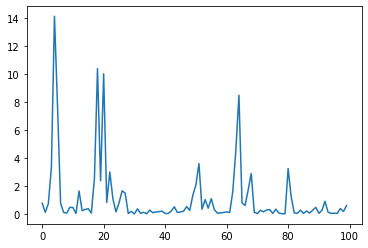

In [342]:
loss = sdg_with_RMSProp(X_train,y_train,64,1,0.9,f1,1000)
plt.plot(range(len(loss[-100:])),loss[-100:])
#sdg使用RMSProb之后收敛速度明显增快
#更大的alpha收敛波动更大，但是收敛的更快

In [343]:
predictlabel = []
for i in X_test:
    predictlabel.append(f1.predict(i))

In [344]:
pre = np.array(predictlabel)
acc1 = acc(y_test,pre)
print(acc1)

0.9663299663299664


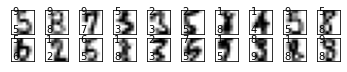

In [345]:
wrongim = []
for i in range(y_test.size):
    if pre[i] != y_test[i]:
        wrongim.append((i,X_test[i].reshape(8,8)))
fig = plt.figure()
for i in range(len(wrongim)):
    ax = fig.add_subplot(8,10,i+1, xticks=[], yticks=[])
    ax.imshow(wrongim[i][1],cmap=plt.cm.binary)
    ax.text(0, 1, str(pre[wrongim[i][0]]))
    ax.text(0, 7, str(y_test[wrongim[i][0]]))

In [346]:
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [347]:
acc2 = clf.score(X_test,y_test)
print("sklearn库函数在测试集上的的acc是：",acc2)
print("我实现的算法在测试集上的acc是:",acc1)


sklearn库函数在测试集上的的acc是： 0.9747474747474747
我实现的算法在测试集上的acc是: 0.9663299663299664


In [ ]:
#overfiting